# RAPIDS & Music: Related Artists Prediction from Playlists

### ASONAM 2019 Tutorial
### Authors
 - Corey Nolet [cnolet@nvidia.com]

### Table of Contents
* Introduction
* Data Importing and Formatting
* Data Exploration
  * Investigating artists
  * 
* Build Playlist Predictor
    
### Development Notes
 - Developed using: RAPIDS v0.9.0
 - Last tested using: RAPIDS v0.9.0 on August 20, 2019

In [1]:
import cudf
import cugraph
import cuml

import numpy as np

%matplotlib inline

In [2]:
from librmm_cffi import librmm as rmm
from librmm_cffi import librmm_config as rmm_cfg

rmm_cfg.use_managed_memory = True
rmm_cfg.use_pool_allocator = False
rmm.initialize() 

0

## Introduction

Predicting songs for users is a common problem faced by companies like Spotify and Tidal and a lot can be learned by analyzing the playlists generated by users. Playlists are formed by grouping artists and songs together into a themed collection. In this notebook, we will explore the Spotify Million Playlist Dataset, which was created for the RecSys 2018 competition, and see if we can build a playlist recommender. We will 

1. Perform exploratory analysis of the datast,
2. 
3. Perform graph analytics on the graph representation of the cyber network data, and
4. Prepare the results in a way that is suitable for visualization.



### TODO: Add information about the dataset, along with a link to the RecSys 2018 dataset page

## Load and Explore Dataset

First let's load our dataset onto the GPU

In [3]:
%%time
gdf = cudf.read_csv("../data/million_playlist_dataset.csv")

CPU times: user 12.3 s, sys: 5.22 s, total: 17.5 s
Wall time: 17.6 s


Let's take an initial look at our data. We notice we have all the tracks for each playlist as seperate entries in the dataframe. 

In [4]:
%%time
gdf.head()

CPU times: user 576 ms, sys: 88 ms, total: 664 ms
Wall time: 688 ms


,artist_name,artist_uri,description,name,num_followers,pid,pos,track_name,track_uri
0,Futuristic,spotify:artist:5Z5jUyiNvFaqp0EVyLNf0p,null,Summer 2017,2,814000,0,Epiphany (feat. NF),spotify:track:1QOqNh2GvfN0ToramLPw5R
1,Flame,spotify:artist:2s6kyMmJZFgPCHXU0QxJLp,null,Summer 2017,2,814000,1,Start Over (feat. NF),spotify:track:57AlxjJrWpWg0vF7eGksir
2,NF,spotify:artist:6fOMl44jA4Sp5b9PpYCkzz,null,Summer 2017,2,814000,2,Can You Hold Me,spotify:track:1isXdpzFMO6EIkgdWjV2D8
3,NF,spotify:artist:6fOMl44jA4Sp5b9PpYCkzz,null,Summer 2017,2,814000,3,Just Being Me,spotify:track:44vMHn5aDNEkUdQmonvHp3
4,NF,spotify:artist:6fOMl44jA4Sp5b9PpYCkzz,null,Summer 2017,2,814000,4,Only One,spotify:track:1iAqQMUVtp5E1EYJkqZw2g


### Explore Tracks

We can count the number of unique playlists in our dataset. Not surprisingly, we have 1M of them

In [5]:
%%time
gdf.pid.unique().shape

CPU times: user 412 ms, sys: 128 ms, total: 540 ms
Wall time: 556 ms


(1000000,)

And see that we have 66M entries of tracks across all the playlists

In [6]:
%%time
gdf.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.2 µs


(66346428, 9)

The dataset contains nearly 2.2M unique tracks

In [7]:
%%time
n_tracks = gdf.track_uri.unique().shape[0]
n_tracks

CPU times: user 6.07 s, sys: 3 s, total: 9.07 s
Wall time: 9.06 s


2262292

Interestingly, it also contains a large number of different tracks with duplicate names. 

In [8]:
%%time
n_track_names = gdf.track_name.unique().shape[0]
n_track_names

CPU times: user 1.92 s, sys: 824 ms, total: 2.74 s
Wall time: 2.74 s


1483760

Over 34% of the track names are duplicates?!? 

Seems strange, but no. Spotify categorizes a `track` as a song from an artist on an album. This means the same song appearing on multiple albums (eg various artist compilations, greatest hits) will occur more than once. 

In [9]:
1 - (n_track_names / n_tracks)

0.3441341789654032

We can verify this by counting the unique tracks by `artist_uri` without regard to the `track_uri`

In [10]:
unique_tracks = gdf[["artist_uri", "track_name"]].drop_duplicates().shape[0]
unique_tracks

2190142

That seems much more reasonable. Just over 3% are duplicate songs from different artists

In [11]:
1 - (unique_tracks / n_tracks)

0.03189243475201253

### Explore Artists

To get a general feel for the distribution of artists across playlists, let's count the number of times each artist occurs in playlists





Artists can occur in playlists more than once. It's also possible they could occur hundreds to thousands of times in the same playlist. For instance, playlists created by labels and promotional companies will often do this. 

Since we care about the spread and not the depth, let's drop the duplicate artists for each playlist id.

In [12]:
%%time
artists = gdf[["artist_uri", "artist_name", "pid"]].drop_duplicates()

CPU times: user 2.47 s, sys: 1.06 s, total: 3.53 s
Wall time: 3.53 s


We can see the effect of dropping duplicates cut the number of total rows by over `40%`

In [13]:
artists.shape

(38088211, 3)

In [14]:
1 - (artists.shape[0] / gdf.shape[0])

0.4259191919118841

Grouping by the artists and performing a `count()` aggregation allows us to count their spread across playlists

In [15]:
%%time
artists = artists.groupby(["artist_uri", "artist_name"]).count().reset_index()

CPU times: user 1.23 s, sys: 656 ms, total: 1.89 s
Wall time: 1.89 s


In [16]:
%%time
artists = artists.rename({"pid":"count"})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.31 ms


Let's peek at the artists that occur in the most playlists. The results are what we'd expect- the top 40 artists ranging between 2010 and 2017

In [17]:
artists.sort_values("count", ascending=False).head(40)

,artist_uri,artist_name,count
131666,spotify:artist:3TVXtAsR1Inumwj472S9r4,Drake,203345
221282,spotify:artist:5pKCCKE2ajJHZ9KAiaK11H,Rihanna,150344
202188,spotify:artist:5K4W6rqBFWDnAN6FQUkS6x,Kanye West,141223
58791,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,125236
96863,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,120901
233658,spotify:artist:69GGBxA162lTqCwzJG5jLp,The Chainsmokers,111562
252550,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,111422
273619,spotify:artist:7CajNmpbOovFoOoasH2HaY,Calvin Harris,110881
263166,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Beyoncé,97468
2844,spotify:artist:04gDigrS5kc9YWfZHwBETP,Maroon 5,97256


We can peek at the bottom 40 artists (occurring in the lowest number of playlists) and see they are likely not very well-known musicians. 

In [18]:
%%time
artists.sort_values("count", ascending=True).head(40)

CPU times: user 52 ms, sys: 32 ms, total: 84 ms
Wall time: 84.8 ms


,artist_uri,artist_name,count
1,spotify:artist:0001cekkfdEBoMlwVQvpLg,Jordan Colle,1
4,spotify:artist:000DnGPNOsxvqb2YEHBePR,The Ruins,1
7,spotify:artist:000UxvYLQuybj6iVRRCAw1,Primera Etica,1
8,spotify:artist:000YStE477SUgwTTYceARC,Fiona Xsay,1
9,spotify:artist:000h2XLY65iWC9u5zgcL1M,Kosmose,1
10,spotify:artist:000spuc3oKgwYmfg5IE26s,Parliament Syndicate,1
11,spotify:artist:000xagx3GkcunHTFdB4ly0,Moxa,1
12,spotify:artist:0011DpkmiLGXnibZ4oKGB5,Green and Yellow,1
13,spotify:artist:0012MbXnWE3SOtQdfg8CBb,Olivia Cella,1
15,spotify:artist:001NaPzWk3GKPMkuVNMdGd,Cuzzo Shay,1


We can query our favorite artists by their name to see how many unique playlists contain them

In [19]:
%%time
artists[artists.artist_name == "Led Zeppelin"]

CPU times: user 708 ms, sys: 28 ms, total: 736 ms
Wall time: 749 ms


,artist_uri,artist_name,count
117508,spotify:artist:36QJpDe2go2KgaRleHCDTp,Led Zeppelin,29498


How many unique artists in the entire dataset?

In [20]:
%%time
artists.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


(295856, 3)

This is a lot of artists and, from our bottom-40 dataframe above, it looks like there's likely many artists that occur so infrequently that they are unlikely to have any predictive qualities.

We can get a good feel for the actual distribution of artists and the number of playlists that contain them by log transforming our counts. 

In [21]:
%%time
artists["log_count"] = np.log1p(artists["count"].to_pandas())

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 72.8 ms


It's not surprising that this distribution has a very long tail. 

This tells us most of the artists don't occur in many playlists at all. It's likely these are aspiring / bedroom musicians and local artists. Unfortunately, they aren't going to help us predict music for playlists and related artists if we don't have enough data about them to know who their most similar to.

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 27.2 ms


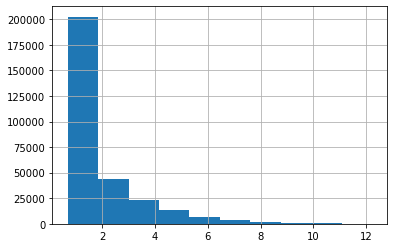

In [22]:
%%time
artists["log_count"].to_pandas().hist()

Let's count exactly how many artists only occur in only a single playlist

In [23]:
%%time
artists[artists["count"]==1].shape

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 37.4 ms


(119746, 4)

### Reduce Artists

We can investigate these counts to find a good threshold that we can use to filter our dataset down a little bit.

By filtering for artists that occur in 50 or more playlists, we could whittle down our list of artists by nearly 8x

In [24]:
%%time
artists[artists["count"]>=50].shape

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 35 ms


(29880, 4)

In [25]:
%%time
artists.shape[0] / artists[artists["count"]>=50].shape[0]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.5 ms


9.901472556894243

Let's try a larger number 

In [26]:
%%time
artists[artists["count"]>1000].shape

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 33.5 ms


(4596, 4)

Looks like 97% of the artists were in less than 1 thousand playlists. This seems like a reasonable noise filter. 

In [27]:
%%time
1 - (artists[artists["count"]>1000].shape[0] / artists.shape[0])

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 28.8 ms


0.9844654156075929

In [28]:
%%time
artists = artists[artists["count"]>1000]

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 29.3 ms


Still, none of these artists are familiar but `1K` out of `1M` playlists is `0.1%` and that seems like a reasonable enough popularity to keep them. Also, if you have heard of these artists then you could lower the threshold even more. 

In [29]:
artists.sort_values("count", ascending=True).head()

,artist_uri,artist_name,count,log_count
66929,spotify:artist:1lQO7ePBTp5yOfVK9hicoJ,Fidel Rueda,1001,6.909753
156206,spotify:artist:47opbYEKDjXnRk9uLscp11,Yolanda Adams,1001,6.909753
284020,spotify:artist:7gkRNHOOt7QfhhXf0rEnmj,+44,1001,6.909753
20797,spotify:artist:0Y619QjWhmBbSV5LGZN7oi,The Real Tune,1002,6.910751
226941,spotify:artist:5yCd7bxcAc3MdQ1h54ESsD,Houston,1002,6.910751


In [30]:
%%time
artists = artists[["artist_uri"]]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 995 µs


### Filter Dataset

We can filter the full dataset down using a left inner join on the `artist_uri`

In [31]:
%%time
gdf = artists.merge(gdf, on="artist_uri", how="left")

CPU times: user 3min 1s, sys: 1min 24s, total: 4min 25s
Wall time: 4min 25s


In [32]:
gdf.head()

,artist_uri,artist_name,description,name,num_followers,pid,pos,track_name,track_uri
0,spotify:artist:7sgWBYtJpblXpJl2lU5WVs,Electric Guest,null,WORKOUT,3,814479,81,Oh Devil,spotify:track:1DnJlbiELCQcZJwywwBOKC
1,spotify:artist:7siPLyFwRFYQkKgWKJ5Sod,The Dandy Warhols,null,Test,1,814288,29,The Last High,spotify:track:4jWtqHOLwFoXMsXtlnBK7v
2,spotify:artist:7slfeZO9LsJbWgpkIoXBUJ,Ricky Martin,null,Soft,2,814708,56,El Ultimo Adiós - Varios Artistas Version,spotify:track:0tzixmHNQfE6S6SirSToxW
3,spotify:artist:7so1HCxGkBmfqdvIF5HzkT,Lawrence Taylor,null,VIBES,1,814686,16,Bang Bang,spotify:track:3lVRPH9P6BpD9lamNSyrp2
4,spotify:artist:7t0rwkOPGlDPEhaOcVtOt9,The Cranberries,null,80,1,814689,26,Linger,spotify:track:1aLNpg2kKvUncflV8xE5AA


In [33]:
gdf.shape

(56103086, 9)

## Build Link Predictor for Related Artists

Now that we've reduced our dataset, we can begin to create a small link predictor to find artists related to a given playlist. 

We can use cuGraph's `Jaccard similarity` analytic to help us with the link prediction.


**Problem:** Given a playlist, we want to see if we can find similar artists by looking at other similar playlists. 

### Construct Bipartite Playlist/Artist Graph

To save memory, we can select only the columns we need for our graph. 

The fields `artist_uri` and `pid` will become our `src` and `dst` edge lists. 

In [34]:
%%time
graph_gdf = gdf[["artist_uri", "pid"]]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 581 µs


In [35]:
graph_gdf.head()

,artist_uri,pid
0,spotify:artist:7sgWBYtJpblXpJl2lU5WVs,814479
1,spotify:artist:7siPLyFwRFYQkKgWKJ5Sod,814288
2,spotify:artist:7slfeZO9LsJbWgpkIoXBUJ,814708
3,spotify:artist:7so1HCxGkBmfqdvIF5HzkT,814686
4,spotify:artist:7t0rwkOPGlDPEhaOcVtOt9,814689


Duplicate edges in the graph aren't needed, so we can drop them to save even more space

In [36]:
%%time
graph_gdf = graph_gdf.drop_duplicates()

CPU times: user 2.45 s, sys: 1.29 s, total: 3.74 s
Wall time: 3.74 s


In [37]:
graph_gdf.shape

(31279849, 2)

cuGraph will expect us to provide vertices in the form of 32-bit integers. We can use cuML's `LabelEncoder` to do this transformation on the GPU.

Since we need to treat our `artist_uri` and `pid` vertices are different types, we will need to make sure their encoded categories won't collide. This can be accomplished by adding a simple offset to the `artist_uri`

In [38]:
%%time
le = cuml.preprocessing.LabelEncoder()
graph_gdf["artist_enc"] = le.fit_transform(graph_gdf["artist_uri"])+1000000

CPU times: user 524 ms, sys: 252 ms, total: 776 ms
Wall time: 783 ms


Sanity check to make sure we have the expected number of artists

In [39]:
%%time
graph_gdf["artist_enc"].unique().shape

CPU times: user 120 ms, sys: 44 ms, total: 164 ms
Wall time: 162 ms


(4596,)

Let's see how many playlists & songs we have now. Still fairly close to `1M`.

In [40]:
graph_gdf.pid.unique().shape

(988467,)

Our bipartite graph needs to be undirected, however, it currently only has edges pointing from artists to playlists. 

We can symmetrize our graph on GPU by concatenating the playlist and artist edge lists. 

In [41]:
%%time
graph_gdf.pid = graph_gdf.pid.astype("int32")
graph_gdf.artist_enc = graph_gdf.artist_enc.astype("int32")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.41 ms


In [42]:
src_edges = cudf.concat([graph_gdf.pid, graph_gdf.artist_enc]).reset_index()["pid"]
dst_edges = cudf.concat([graph_gdf.artist_enc, graph_gdf.pid]).reset_index()["artist_enc"]
weights = cudf.concat([cudf.Series(np.ones(graph_gdf.pid.shape[0])), cudf.Series(np.zeros(graph_gdf.pid.shape[0]))])

new_graph_gdf = cudf.DataFrame()
new_graph_gdf["src"] = src_edges
new_graph_gdf["dst"] = dst_edges
new_graph_gdf["weights"] = weights

And we can renumber our vertices to make sure they start at zero and increase monotonically.

In [43]:
%%time
new_graph_gdf["src_id"], new_graph_gdf["dst_id"], numbering = cugraph.renumber(src_edges, dst_edges)

CPU times: user 256 ms, sys: 104 ms, total: 360 ms
Wall time: 361 ms


Now that we have combine the artist and playlist id vertex numbers, we can be confident ids >= 1M are going to be artists. 

In [44]:
new_graph_gdf.head()

,src,dst,weights,src_id,dst_id
0,16,1000000,1.0,1952,84993
1,33,1000000,1.0,4021,84993
2,97,1000000,1.0,11797,84993
3,112,1000000,1.0,13624,84993
4,138,1000000,1.0,16787,84993


In [45]:
new_graph_gdf[new_graph_gdf.src_id==0]

,src,dst,weights,src_id,dst_id
151718,0,1000021,1.0,0,87552
594415,0,1000084,1.0,0,95215
893899,0,1000121,1.0,0,99720
1511321,0,1000224,1.0,0,112250
1803555,0,1000257,1.0,0,116259
2938040,0,1000402,1.0,0,133888
3625809,0,1000490,1.0,0,144601
3983760,0,1000564,1.0,0,153612
5200895,0,1000752,1.0,0,176462
6450644,0,1000929,1.0,0,197967


Create our cuGraph using our edge lists

In [46]:
%%time
G = cugraph.Graph()
G.add_edge_list(new_graph_gdf["src_id"], new_graph_gdf["dst_id"], new_graph_gdf["weights"])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.42 ms


Since our graph is bipartite, we cannot just pass it into the Jaccard computation as-is. This would cause it only to traverse a single hop (eg from playlists to users and users to playlists) and would not find any intersections. 

We want to get the edge lists for the two-hop neighbors.

In [47]:
%%time
two_hop = G.get_two_hop_neighbors()

CPU times: user 1.49 s, sys: 860 ms, total: 2.35 s
Wall time: 2.34 s


In [48]:
%%time
two_hop.head()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.3 ms


,first,second
0,848487,0
1,848487,1
2,848487,3
3,848487,4
4,848487,6


In [49]:
two_hop[two_hop.first==0]

,first,second


### Explore Some Playlists

Let's explore a playlist by querying our original dataframe for a specific artist

In [50]:
%%time
gdf[gdf.artist_name == "My Chemical Romance"].sort_values("pid", ascending=True).head(50)

CPU times: user 12.5 s, sys: 5.89 s, total: 18.4 s
Wall time: 18.4 s


,artist_uri,artist_name,description,name,num_followers,pid,pos,track_name,track_uri
23821851,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,144,Teenagers,spotify:track:7j31rVgGX9Q2blT92VBEA0
23821858,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,145,Helena (So Long & Goodnight),spotify:track:5dTHtzHFPyi8TlTtzoz1J9
23821865,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,146,Famous Last Words,spotify:track:2d6m2F4I7wCuAKtSsdhh83
23821873,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,147,Na Na Na [Na Na Na Na Na Na Na Na Na],spotify:track:5BB0Jzw60KyfSTyjJqtely
23821881,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,148,Fake Your Death,spotify:track:2M8g01v2vUMn39YQ10l7ef
23821887,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,149,I'm Not Okay (I Promise),spotify:track:7lRlq939cDG4SzWOF4VAnd
23821895,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,161,House of Wolves,spotify:track:7j2Bmzpnf6RwEWEQ2sv8Ho
23821902,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,Everything,9,231,143,Welcome to the Black Parade,spotify:track:5wQnmLuC1W7ATsArWACrgW
23821917,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,songs that make me think of you,1,394,5,You Know What They Do To Guys Like Us In Prison,spotify:track:5bTuwAgYUD5MABOIPH8ZMt
23831844,spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,null,⚡️,1,404,49,The Jetset Life Is Gonna Kill You,spotify:track:7HKfrU3iuEFrKxTAfVznrG


Here's the full set of artists in one of the playlists above

In [51]:
%%time
gdf[gdf.pid==573].artist_name

CPU times: user 708 ms, sys: 292 ms, total: 1 s
Wall time: 1 s


2785018                Go Radio
6063682           Peter Hollens
10020486    Andrew Lloyd Webber
16882518        Plain White T's
18135123      A Day To Remember
18521027              Passenger
19748310        Christina Perri
19748322        Christina Perri
19911513           All Time Low
19911520           All Time Low
19925834           All Time Low
21944781    5 Seconds of Summer
21944792    5 Seconds of Summer
21944797    5 Seconds of Summer
21944802    5 Seconds of Summer
21944808    5 Seconds of Summer
21944814    5 Seconds of Summer
21944821    5 Seconds of Summer
21944827    5 Seconds of Summer
21944834    5 Seconds of Summer
21958311    5 Seconds of Summer
21958318    5 Seconds of Summer
21958325    5 Seconds of Summer
21958330    5 Seconds of Summer
21958336    5 Seconds of Summer
21958342    5 Seconds of Summer
21958348    5 Seconds of Summer
21958353    5 Seconds of Summer
21958360    5 Seconds of Summer
21958367    5 Seconds of Summer
                   ...         
34056811

And, to make it easier to read, we can list just the unique set of artists

In [52]:
%%time
plist_orig = gdf[gdf.pid==573].artist_name.unique()
plist_orig

CPU times: user 660 ms, sys: 348 ms, total: 1.01 s
Wall time: 1.01 s


0     5 Seconds of Summer
1       A Day To Remember
2            All Time Low
3     Andrew Lloyd Webber
4              Bruno Mars
5         Christina Perri
6               Disturbed
7              Ed Sheeran
8                  Eminem
9            Fall Out Boy
10               Go Radio
11              Green Day
12           Led Zeppelin
13    My Chemical Romance
14    Panic! At The Disco
15              Passenger
16          Peter Hollens
17        Plain White T's
18            Troye Sivan
19              blink-182
Name: artist_name, dtype: object

cuGraph's Jaccard computation allows us to pass a list of src/dst vertices to compute, so that we don't have to compute all possible combinations.

We can use this playlist id as our source and compute the Jaccard similarities from that playlist to every other playlist.

In [53]:
%%time
original_pid = 573
pid = numbering[numbering == original_pid].index[0]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.22 ms


In [54]:
%%time
clist = cudf.DataFrame()
clist["second"] = two_hop.second.unique().astype("int32")

CPU times: user 1.82 s, sys: 284 ms, total: 2.11 s
Wall time: 2.11 s


In [55]:
%%time
clist["first"] = pid.astype("int32")

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 64.1 ms


In [56]:
%%time
clist.sort_values("second", ascending=False).head()

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 28.6 ms


,second,first
985010,993062,69684
985009,993061,69684
985008,993060,69684
985007,993059,69684
985006,993058,69684


In [57]:
%%time
jacc = cugraph.jaccard(G, first=clist.first, second=clist.second)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.9 ms


Sorting our results in descending order by the Jaccard coefficient allows us to look at the most similar playlists first. 

In [58]:
%%time
jacc.sort_values("jaccard_coeff", ascending=False).head(25)

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 36.2 ms


,source,destination,jaccard_coeff
69424,69684,69684,1.000000
628238,69684,635007,0.333333
721866,69684,729053,0.320000
271176,69684,273662,0.291667
853047,69684,860661,0.291667
85772,69684,86102,0.289474
862395,69684,870035,0.280000
207958,69684,209698,0.275862
252146,69684,254416,0.275862
876096,69684,883779,0.275000


Let's reverse the encoding of our playlist id so that we can look at the artists in a couple of the most similar playlists

In [59]:
%%time
pid = numbering[635007]
pid

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 379 µs


218188

In [60]:
%%time
plist_a = gdf[gdf.pid == pid].artist_name.unique()
plist_a

CPU times: user 712 ms, sys: 308 ms, total: 1.02 s
Wall time: 1.02 s


0      5 Seconds of Summer
1        A Day To Remember
2             All Time Low
3     Bring Me The Horizon
4                Green Day
5      My Chemical Romance
6                 Paramore
7          Plain White T's
8              Simple Plan
9              Troye Sivan
10            We The Kings
11               blink-182
Name: artist_name, dtype: object

In [61]:
%%time
pid = numbering[729053]
plist_b = gdf[gdf.pid == pid].artist_name.unique()
plist_b

CPU times: user 652 ms, sys: 372 ms, total: 1.02 s
Wall time: 1.02 s


0                   3OH!3
1            All Time Low
2              Ed Sheeran
3            Fall Out Boy
4               Green Day
5                  Halsey
6        Melanie Martinez
7     My Chemical Romance
8     Panic! At The Disco
9     Secondhand Serenade
10            Troye Sivan
11      Twenty One Pilots
12              blink-182
Name: artist_name, dtype: object

We can remove the intersection of all the playlists to get the artists that weren't in the original. 

In [ ]:
union = cudf.concat([plist_a, plist_b]).reset_index().drop_duplicates()
union["new"] = union["artist_name"].isin(plist_orig)
union[union.new == False].artist_name.unique()

Let's try another artist. We can go for one of the most popular- The Beatles

In [ ]:
gdf[gdf.artist_name == "The Beatles"].head(50)

One of the problems using playlists to detminermine artist similarity is the playlists vary widely in their levels of entropy- some are composed of a single style and time period while others are spread over several styles and time periods. 

In [ ]:
gdf[gdf.pid == 155151].artist_name.unique()

In [ ]:
clist["second"] = two_hop.second.unique().astype("int32")

In [ ]:
clist["first"] = numbering[numbering==155151].index[0].astype("int32")

In [ ]:
clist.sort_values("second", ascending=False).head()

In [ ]:
%%time
jacc = cugraph.jaccard(G, first=clist.first, second=clist.second)

In [ ]:
%%time
jacc.sort_values("jaccard_coeff", ascending=False).head(15)

In [ ]:
pid = numbering[782501]

In [ ]:
gdf[gdf.pid==pid].artist_name.unique()

Let's conclude our artist similarity predictor with one more example, taken from 90's rock bands. 

In [ ]:
gdf[gdf.artist_name == "Foo Fighters"].head(25)

We can choose an unencoded playlist id from the list above and take a look at all the unique artists in it

In [ ]:
%%time
gdf[gdf.pid==814771].artist_name.unique()

In order to query this playlist in our graph, we'll encode it using our vertex renumbering mapping,

In [ ]:
%%time
pid_enc = numbering[numbering == 814771].index[0]

build our Jaccard filter list...

In [ ]:
%%time
clist["second"] = two_hop.second.unique().astype("int32")

In [ ]:
%%time
clist["first"] = pid_enc.astype("int32")

In [ ]:
clist.sort_values("second", ascending=False).head()

and compute our similarities.

In [ ]:
%%time
jacc = cugraph.jaccard(G, first=clist.first, second=clist.second)

In [ ]:
%%time
jacc.sort_values("jaccard_coeff", ascending=False).head()

This time, instead of just manually looking up one playlist at a time, let's take a different approach and grab artists from the `n` closest playlist ids

In [ ]:
%%time
n = 50
recc_pid_enc = jacc.sort_values("jaccard_coeff", ascending=False)["destination"][1:n]

In [ ]:
pids = numbering[recc_pid_enc].to_array()

In [ ]:
pids

We can also rank the similarity of the artists based on how many of the above playlists they occur in

In [ ]:
%%time
query = gdf[gdf.pid.isin(pids)][["artist_name", "artist_uri", "pid"]].drop_duplicates()
query = query.groupby(["artist_name"]).count().reset_index()

In [ ]:
%%time
query = query.rename({"artist_uri": "count"})

In [ ]:
%%time
query.sort_values("count", ascending=False).head(25)

We can look at some of the "noise" at the bottom of the list and see that they are less relevant to our query artist than the ones at the top of the list

In [ ]:
%%time
query.sort_values("count", ascending=True).head(30)

## Build Collaborative Filtering Dataset

Let's conclude by transforming our dataset into a format that can be used to train collaborative filtering models. 

We don't have any explicit ratings of artists, but we do have the jaccard similarities for each of the playlists. This can allow us to do playlist-playlist similarity by embedding our jaccard scores into a continuous vector space.

In [50]:
%%time
jacc = cugraph.jaccard(G, two_hop.first, two_hop.second)

CPU times: user 384 ms, sys: 340 ms, total: 724 ms
Wall time: 720 ms


In [51]:
jacc.head()

,source,destination,jaccard_coeff
0,848487,0,0.019417
1,848487,1,0.033058
2,848487,3,0.008696
3,848487,4,0.014085
4,848487,6,0.013158


In [52]:
jacc.shape

(139802415, 3)

In [53]:
jacc[jacc.source >= 1000000]

,source,destination,jaccard_coeff


We only want the source ids for artists

In [54]:
new_graph_gdf.head()

,src,dst,weights,src_id,dst_id
0,16,1000000,1.0,1952,84993
1,33,1000000,1.0,4021,84993
2,97,1000000,1.0,11797,84993
3,112,1000000,1.0,13624,84993
4,138,1000000,1.0,16787,84993


In [55]:
new_graph_gdf.shape

(62559698, 5)

We can store our original dataframe out to host memory to save some space on the GPU

In [56]:
%%time
gdf = gdf.to_pandas()

CPU times: user 23.2 s, sys: 7.03 s, total: 30.2 s
Wall time: 30.2 s


This will allow us to merge our jaccard weights into our graph dataframe

In [83]:
%%time

tmp_df = cudf.DataFrame()
tmp_df["src"] = new_graph_gdf["src"]
tmp_df["src_id"] = new_graph_gdf["src_id"]

tmp_df = tmp_df.drop_duplicates()

CPU times: user 332 ms, sys: 152 ms, total: 484 ms
Wall time: 481 ms


In [84]:
jacc[jacc.jaccard_coeff>=1000000]

,source,destination,jaccard_coeff


In [59]:
collab_filt = tmp_df.merge(jacc, right_on="source", left_on="src_id", how="left")

In [60]:
collab_filt.head()

,src,src_id,source,destination,jaccard_coeff
0,64779,902782,902782,null,null
1,64780,902903,902903,null,null
2,64781,903024,903024,null,null
3,64782,903142,903142,null,null
4,64783,903263,903263,null,null


In [62]:
collab_filt.sort_values("jaccard_coeff", ascending=False).head()

,src,src_id,source,destination,jaccard_coeff
3137185,15184,848621,848621,25809,1.0
3137889,15184,848621,848621,19813,1.0
3142077,15184,848621,848621,49975,1.0
3142405,15184,848621,848621,49055,1.0
3144521,15184,848621,848621,71929,1.0


In [63]:
%%time

tmp_df = cudf.DataFrame()
tmp_df["dst"] = new_graph_gdf["dst"]
tmp_df["dst_id"] = new_graph_gdf["dst_id"]

tmp_df = tmp_df.drop_duplicates()

CPU times: user 288 ms, sys: 136 ms, total: 424 ms
Wall time: 423 ms


In [64]:
tmp_df.shape

(993063, 2)

In [65]:
collab_filt = tmp_df.merge(collab_filt, right_on="destination", left_on="dst_id", how="left")

In [76]:
collab_filt.sort_values("jaccard_coeff", ascending=True).head()

,dst,dst_id,src,src_id,source,destination,jaccard_coeff
,,,,,,,
77059858,551912,378892,187196,848764,848764,378892,0.003021
104483148,748369,363479,187196,848764,848764,363479,0.003135
3531115,47101,746483,228151,848769,848769,746483,0.003175
52927036,379527,333392,187196,848764,848764,333392,0.003247
10775752,83820,232259,228151,848769,848769,232259,0.003268


In [67]:
collab_filt.to_csv("../data/collab_filter_train.csv")

In [97]:
collab_filt[collab_filt.dst<1000000].shape

(139805871, 7)

In [88]:
collab_filt.shape

(139810467, 7)

In [ ]:
pa = np.array(gdf[gdf.pid == numbering[848487]].artist_name.unique())

In [ ]:
pb = np.array(gdf[gdf.pid==numbering[299262]].artist_name.unique())

In [ ]:
len(np.intersect1d(pa, pb))

In [ ]:
39/len(pa)+len(pb)

In [ ]:
%%time
gdf.num_followers.unique()

In [ ]:
%%time
gdf[gdf.num_followers < 20].shape[0] / gdf.shape[0]

In [ ]:
%%time
gdf[gdf.num_followers<20].num_followers.to_pandas().hist()

In [ ]:
%%time
gdf["num_followers_norm"] = np.log1p(gdf.num_followers.to_pandas())

In [ ]:
%%time
min_val = gdf["num_followers_norm"].min()
max_val = gdf["num_followers_norm"].max()
gdf["num_followers_norm"] = ((gdf["num_followers_norm"]-min_val) / (max_val-min_val)) * (10-1)+1

In [ ]:
%%time
gdf["num_followers_norm"].to_pandas().hist()

In [ ]:
%%time
gdf["num_followers_norm"].max()

In [ ]:
%%time
gdf["num_followers_norm"].min()

In [ ]:
gdf.columns

In [140]:
collab_filter_train = gdf[["artist_uri", "pid", "num_followers_norm"]]

In [141]:
from fastai.collab import *

In [142]:
%%time
le = cuml.preprocessing.LabelEncoder()
collab_filter_train["artist_uri"] = le.fit_transform(collab_filter_train["artist_uri"])

CPU times: user 2.26 s, sys: 1.04 s, total: 3.3 s
Wall time: 3.29 s


In [143]:
%%time
pid_le = cuml.preprocessing.LabelEncoder()
collab_filter_train["pid"] = pid_le.fit_transform(collab_filter_train["pid"])

CPU times: user 1.77 s, sys: 796 ms, total: 2.57 s
Wall time: 2.57 s


In [144]:
collab_filter_train.head()

,artist_uri,pid,num_followers_norm
0,2464,789601,1.000000
1,2465,789738,1.594901
2,2466,789737,2.836736
3,2467,61274,1.000000
4,2468,789708,1.347995


In [149]:
%%time
data = CollabDataBunch.from_df(collab_filter_train.to_pandas(), 
                               user_name="pid", 
                               item_name="artist_uri", 
                               rating_name="num_followers_norm")

CPU times: user 40.4 s, sys: 16.6 s, total: 57 s
Wall time: 56.3 s


In [150]:
%%time
y_range = [collab_filter_train["num_followers_norm"].min(), collab_filter_train["num_followers_norm"].max()]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.65 ms


In [151]:
y_range

[1.0, 10.0]

In [154]:
%%time
learn = collab_learner(data, n_factors=25, y_range=y_range, path="collab_filter_model")

CPU times: user 1.34 s, sys: 76 ms, total: 1.41 s
Wall time: 405 ms


In [155]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,time
0,0.199590,0.212780,1:10:13
1,0.186751,0.192267,1:09:53
2,0.090717,0.094251,1:09:40
3,0.041679,0.043450,1:09:52


In [242]:
collab_filter_train[collab_filter_train.artist_uri==4700]

,artist_uri,pid_y,num_followers_norm
5500,4700,61173,0.693147
5532,4700,61715,0.693147
5564,4700,61693,0.693147
23228,4700,61747,0.693147
23260,4700,794638,0.693147
23292,4700,794638,0.693147
44044,4700,794792,1.098612
44076,4700,908766,0.693147
44108,4700,908766,0.693147
62690,4700,908766,0.693147


In [82]:
learn.export('collaborative_filtering_model.pkl')

In [101]:
learn.predict(collab_filter_train.to_pandas().iloc[50000])

(FloatItem 0.6958642, tensor(0.6959), tensor(0.6959))

In [128]:
embeds = to_np(learn.model.u_weight.weight)

In [129]:
from cuml.manifold import UMAP

In [131]:
umap = UMAP()
umap.fit(embeds)

/raid/cjnolet/conda/cuml_dev_10/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/raid/cjnolet/conda/cuml_dev_10/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


UMAP(n_neighbors=15, verbose=False, handle=<cuml.common.handle.Handle object at 0x7f0bc222c168>, callback=None)

In [132]:
umap_embeddings = umap.fit_transform(embeds)

/raid/cjnolet/conda/cuml_dev_10/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


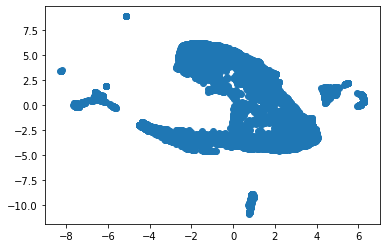

In [138]:
import matplotlib.pyplot as plt
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1])

plt.show()

In [102]:
collab_filter_train.to_pandas().iloc[50000]

artist_uri             2495.000000
pid_y                 61747.000000
num_followers_norm        0.693147
Name: 50000, dtype: float64

In [150]:
from cuml.neighbors import NearestNeighbors

In [193]:
nn = NearestNeighbors(n_neighbors=15)

In [206]:
nn.fit(embeds)

NearestNeighbors(n_neighbors=15, n_gpus=1, devices=None, verbose=False, handle=<cuml.common.handle.Handle object at 0x7f07bb27e060>)

In [207]:
dists, inds = nn.kneighbors(embeds)

In [232]:
inds[1215]

array([1215., 5738., 4894., 4700., 4493., 1494.,  512., 5355., 1619., 4744., 5857., 4119., 2784., 4939.,   40.])

In [245]:
to_np(learn.model.i_bias.weight)[:,0].shape

(993628,)